In [134]:
import agate
import agateexcel
import datetime
import re

In [152]:
solrdump=agate.Table.from_xlsx('SOLR_Data1_original.xlsx')
print(solrdump)

| column        | data_type |
| ------------- | --------- |
| dcrType       | Text      |
| blogType      | Text      |
| articleId     | Number    |
| publishDate   | DateTime  |
| sectionPath   | Text      |
| storyKeywords | Text      |
| webHeadline   | Text      |
| collatedTags  | Text      |
| origin        | Text      |



In [147]:
#GETTING THE PUSBLISH TIME DATA

In [154]:
with_publish_time_extracted=solrdump.compute([
    ('publish_time', agate.Formula(agate.Number(), lambda row: row[3].time().hour))
    
])

In [155]:
by_publish_hour=with_publish_time_extracted.group_by('publish_time')

In [156]:
hour_totals=by_publish_hour.aggregate([
    ('count',agate.Count())
])
print(hour_totals)
sorted_hour_totals=hour_totals.order_by('publish_time')
sorted_hour_totals.print_table(max_rows=5)

| column       | data_type |
| ------------ | --------- |
| publish_time | Number    |
| count        | Number    |

| publish_time | count |
| ------------ | ----- |
|            0 |   729 |
|            1 |   945 |
|            2 |   795 |
|            3 |   447 |
|            4 |   246 |
|          ... |   ... |


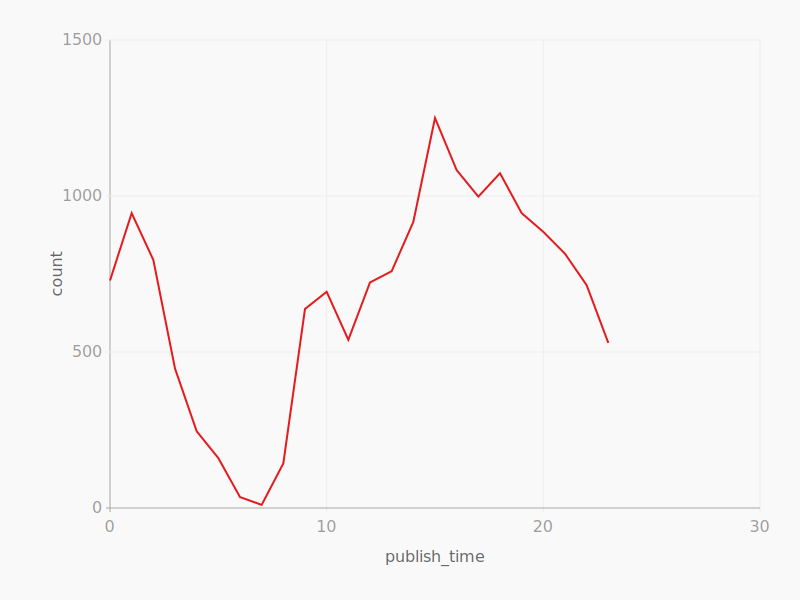

In [157]:
sorted_hour_totals.line_chart('publish_time','count')

In [160]:
#Visualizing the Posts by Hour for each month
print(solrdump)
print(solrdump.rows[0][3].month)

| column        | data_type |
| ------------- | --------- |
| dcrType       | Text      |
| blogType      | Text      |
| articleId     | Number    |
| publishDate   | DateTime  |
| sectionPath   | Text      |
| storyKeywords | Text      |
| webHeadline   | Text      |
| collatedTags  | Text      |
| origin        | Text      |

11


In [281]:
#getting data for each month
#post_type can be StaffArticle or BlogArticle 
import pytz
import leather

eastern = pytz.timezone('US/Eastern')

def visualize_by_month(dataset, m, d, y, post_type):
    monthly_data = dataset.where(lambda row: (datetime.datetime(y, m, 1).replace(tzinfo=row['publishDate'].tzinfo)
                           <= row['publishDate'] 
                           <= datetime.datetime(y, m, d).replace(tzinfo=row['publishDate'].tzinfo))
                           and row['dcrType']==post_type)
    
#     monthly_data=dataset.where(lambda row: row[3].month==m and row[3].year==y and row[0]==post_type )
    
    added_publish_time=monthly_data.compute([
    ('publish_time', agate.Formula(agate.Number(), lambda row: row['publishDate'].time().hour + 20
                                   if row['publishDate'].time().hour - 4 < 0 
                                   else row['publishDate'].time().hour - 4))
    
])
    grouped_by_publish_time=added_publish_time.group_by('publish_time')
    hour_totals=grouped_by_publish_time.aggregate([
        ('count',agate.Count())
        ])
    sorted_hour_totals=hour_totals.order_by('publish_time')
    
    chart = leather.Chart('Stories posted in month by hour')
    chart.add_y_axis(name='Number of stories')
    chart.add_x_axis(name='Hour posted', ticks=range(0,24))
    chart.add_x_scale(0, 24)
    chart.add_line(sorted_hour_totals, x='publish_time', y='count')

    return chart.to_svg()


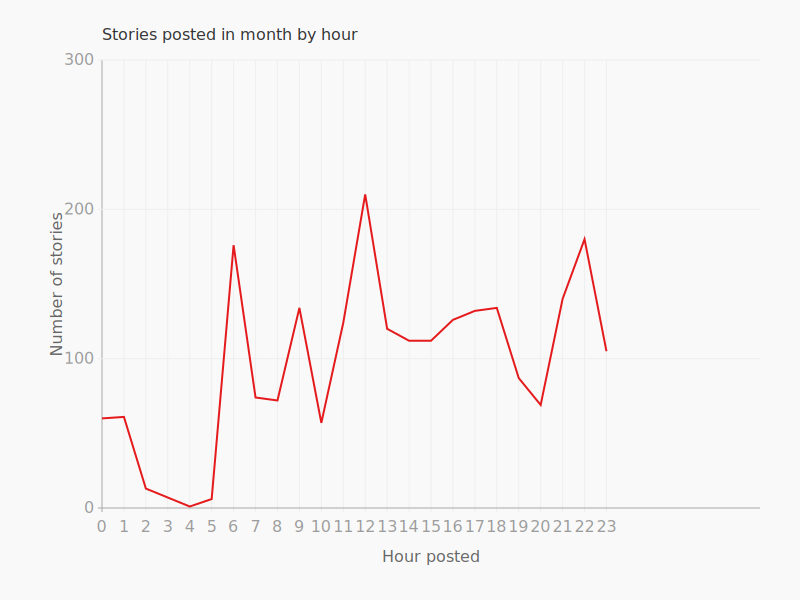

In [282]:
visualize_by_month(solrdump, 2, 28, 2017, "StaffArticle")